### Alvaro Plata (201820098), Brenda Barahona (201812721) , Sofía Álvarez (201729031)

<h1 align='center'>Laboratorio 2: Inteligencia de Negocios</h1>

BancAlpes es una entidad bancaria que está realizando una campaña de fidelización para aumentar la retención de clientes. En concreto, con su estrategía busca fidelizar especialmente a las personas que poseen tarjetas de crédito.
Esta campaña busca ofrecer los mejores productos, servicios y recomendaciones a sus clientes de acuerdo con sus características.
Por esta razón, ha recurrido a ustedes como consultores para que le entreguen al equipo de marketing información que pueda ayudarlos a orientar mejor sus campañas.
En particular, el equipo de marketing espera que le provean grupos a los cuales pueden dirigir sus campañas y las caracteristicas de los clientes en dichos grupos.
BancAlpes considera que esta nueva estrategia de marketing le permitirá aumentar el consumo de productos y servicios y por supuesto, aumentar la retención de clientes.

## 0. Librerias.

In [272]:
# ESAI
seed = 161
# Importamos todas las librerias necesarias para el laboratorio.
import re
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from joblib import dump, load
from matplotlib import cm
from sklearn import tree
from joblib import dump, load
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from pandas_profiling import ProfileReport
from sklearn.pipeline import Pipeline, FeatureUnion
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import recall_score, make_scorer, silhouette_score
from sklearn.metrics import classification_report,silhouette_samples, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## 1. Análisis exploratorio y perfilamiento de los datos.

En esta etapa sabremos cuántos datos tenemos (filas y columnas), el tipo de datos de las columnas, cual es la integridad de los datos, cuál es su distribución (discreta o continua). Ademas, para el caso de las columnas numéricas, usaremos estadística descriptiva sobre los datos, y señalaremos sus principales estadísticos: media, varianza, desviación estándar, etc.  En caso de datos categóricos conoceremos las categorías, los números de registro por categoría, en especial para las categorías con mayor representación en los datos.

Primero leemos los datos y sacamos una muestra, como se ve a continuación:

In [273]:
datos = pd.read_csv('202210_Laboratorio2_data_202210_Lab2_BancAlpes_CC_data.csv', delimiter=',')
datos.sample(5)

,CUST_ID,GENDER,BALANCE,PURCHASES,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_FREQUENCY,PURCHASES_TRX,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE
170,C15735,M,1167.254965,499.92,1.000000,0.0,0.0,1.000000,12000,NaN,0.000000,1200.0,897.514706,1358.434639,12?ñ
3060,C11690,NaN,1624.651156,0.00,0.636364,2684.507978,9.0,0.000000,0,0.0,0.166667,6000.0,894.813551,905.546225,12
237,C16607,F,487.483429,1579.12,1.000000,0.0,0.0,1.000000,21?ñ,NaN,0.000000,10000.0,606.202830,175.917836,12
2325,C13148,M,1552.535280,2072.43,1.000000,0.0,0.0,0.833333,30,0.5,0.000000,7000.0,2522.068213,389.675365,12
2496,C10940,NaN,939.152528,3393.25,1.000000,0.0,0.0,0.250000,5,NaN,0.000000,9000.0,2768.821579,267.093439,12


Veamos, ahora, el número de filas y columnas que tenemos en nuestro conjunto de datos:

In [274]:
print("Número de filas o datos: {}".format(len(datos)))
print("Número de columnas o variables: {}".format(len(datos.columns)))

Número de filas o datos: 5530
Número de columnas o variables: 15


Vemos que tenemos 5530 datos (filas) y 15 columnas (variables). Comparando con el diccionario de datos, vemos que el negocio nos entregó 15 columnas también.

Para ver una exploración más exhaustiva, hicimos un <code>pandas profiling</code> de los datos que nos fueron entregados: 

In [275]:
#profiling = ProfileReport(datos)
#profiling.to_file(output_file="pandas_profiling.html")
#profiling

Haciendo un perfilamiento y análisis exploratorio sobre los datos, encontramos lo siguiente:

<b>Estadísticas generales</b>: Primero, tenemos 5933 celdas con ausencias, lo que corresponde al 7.2% del total del dataset. Para ellas, más adelante, debe implementarse una estrategia de imputación o eliminación, según sea el caso, como se verá más adelante. Asimismo, vemos que no tenemos filas duplicadas.

Las variables que tienen valores vacios son: 
* **OneOffPurchases_frequency** con 2740 celdas vacías (i.e. 49.5%).
* **Gender** con 2714 celdas vacías (i.e. 49.1%).
* **Cash_advance_frequency** con 166 celdas vacías (i.e. 3%).
* **Tenure** con 163 celdas vacías (i.e. 2.9%).
* **Cash_Advance_Trx** con 150 celdas vacías (i.e. 2.7%).

Preliminarmente, podemos ver que las dos primeras variables descritas tienen casi la mitad de ausencias y, posiblemente, deban ser eliminadas del análisis. 

Asimismo, se tienen 9 variables numéricas y 6 categóricas. Esto NO concuerda con el diccionario dado por BancAlpes. Encontramos que el tipo de dato identificado por pandas profiling es incorrecto para las siguientes variables, según lo indicado por el documento del diccionario, pues estas variable deben ser numéricas y fueron clasificadas como categóricas: 
* **CashAdvance:** De acuerdo con el diccionario de datos, es numérica. No obstante, pandas profiling la determina como categórica por la presencia de valores como ?? u otros, en teoría numéricos, que finalizan con ?ñ, como 00.?ñ. Esto debe tratarse en la limpieza de datos, seguramente asumiéndolos como errores de tipeo. 
* **PurchasesTrx:** En este caso, la variable debe ser numérica también. Por tener caracteres con ?, pandas profiling la etiqueta como categórica. Esto debe tratarse en la limpieza de datos, seguramente asumiéndolos como errores de tipeo.
* **Minimum_payments:** Debe ser numérica y es catalogada como categórica por la presencia de caracteres como ??, ñ?, ?. De nuevo, esto será tratado más adelante.
* **Tenure:** Debe ser numérica y, por caracteres extraños como ?, ñ en algunas celdas (o acompañando a ciertos valores numéricos), es definida como categórica.

Para todas estas variables, hay algunos datos con inconsistencias o datos atípicos y, por tanto, deben ser procesados más adelante. 

Ahora, de las variables catalogadas como numéricas, tenemos que las que tienen una distribución continua son:
* **Balance:** Es una variable real distribuida en el rango [-4587.892398, 7390.19856]. De acuerdo con el diccionario y los expertos, esta debe ser siempre positiva y estar en el rango [0, 5000].
* **Balance_frequency:** De acuerdo con el negocio, debe estar distribuida entre 0 y 1. Vemos algunos outliers en 1000.
* **Purchases:** Es una variable real distribuida en el rango [0, 9661.37]. De acuerdo con el negocio, debe estar distribuida entre [0, 15000], por lo que concluimos que los valores se encuentran en el rango definido. Nos parece curioso que haya valores decimales, pues según Bancalpes, esta variable representa la cantidad de compras realizadas por los clientes, y estas deberían ser números enteros. Suponemos, entonces, que se refiere al número promedio de compras realizadas por una cuenta en un intervalo de tiempo determinado.
* **OneOffPurchasesFrequency:** Tiene una distribución continua entre 0 y 1, como es de esperarse de acuerdo con los expertos.
* **Purchases_frequency:** De acuerdo con el negocio, debe estar distribuida entre 0 y 1. Vemos algunos outliers en 1000.

* **Cash_advance_frequency:** Tiene una distribución continua entre 0 y 1.5, cuando su valor máximo debería ser 1. Vemos entonces que hay datos fuera de rango.
* **Credit_limit:** Es una variable con distribución continua en el rango [50, 12500]. De acuerdo con el negocio, esta variable, que representa límite de crédito por usuario, debe estar distribuida entre [0, 10000]. Vemos que hay algunos pocos valores que se salen del límite superior. No obstante, puede tener sentido que algunos usuarios tengan un límite crediticio entre [10000, 12500]. Este tipo de decisiones las trataremos más adelante.  
* **Payments:** Cantidad pagada por el usuario, debe estar distribuida entre [0, 10000] y se encuentra en el rango [0.056466, 9933.62261]. Está adecuadamente distribuida según el negocio.

Además de las variables antes mencionadas, encontramos que hay otras que tambien siguen una distribución continua y que, debido a los outliers y los valores corruptos (i.e. con ñ), no se evidenciaba una clara distribucion de los datos, ya que los rangos con los que pandas contruyó el histograma eran muy grandes.

Por otro lado, vemos que las variables numéricas con distribución discreta son:
* **CashAdvanceTrx:** Parece ser que tiene una distribución discreta, lo cual concuerda con la descripción dada en el diccionario. No obstante, tiene muchos outliers y es difícil saberlo.
* **PurchasesTrx:** Sucede algo similar que con CashAdvanceTrx. 

Un análisis más detallado de las variables numéricas se hará más adelante.

Asimismo, las variables (realmente) categóricas son:
* **CustID:** La identificación del cliente, en que todos los valores son únicos. No da información relevante para el modelo de agrupación.
* **Gender:** Representa el género de la persona. Tiene muchas ausencias, como se mencionó previamente. Una distribución de esta variable la veremos más adelante.

Vemos entonces que la calidad de los datos, en general, no es muy buena. No sólo hay variables con datos fuera de rango según lo definido por el negocio; sino que, además, hay algunos datos inconsistentes (con ?, ñ?, ??, por ejemplo) o nulos (vacíos). Para poder implementar los modelos, es necesario corregir estas inconsistencias en los datos. 

##### Variables numéricas:
Veamos estadísticas descriptivas sobre los datos numéricos:

In [276]:
datos.describe()

,BALANCE,PURCHASES,BALANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,CREDIT_LIMIT,PAYMENTS
count,5530.000000,5530.000000,5530.000000,5380.000000,5530.000000,2790.000000,5364.000000,5530.000000,5530.000000
mean,1041.700463,534.577103,26.482552,49.115428,12.206006,0.148298,0.119005,3588.095256,1107.989817
std,1353.093044,773.488745,152.899316,573.817771,93.757671,0.241687,0.173206,2640.396238,1270.892564
min,-4587.892398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.056466
25%,74.060304,0.000000,0.833333,0.000000,0.000000,0.000000,0.000000,1500.000000,345.431102
50%,632.743634,269.130000,1.000000,0.000000,0.363636,0.000000,0.000000,2900.000000,671.001700
75%,1545.808455,723.700000,1.000000,3.000000,0.833333,0.166667,0.166667,5000.000000,1354.931507
max,7390.198560,9661.370000,1000.000000,18000.000000,1000.000000,1.000000,1.500000,12500.000000,9933.622610


En este punto, podemos obtener información más detallada sobre las variables numéricas. Veamos:
* **BALANCE:** Como se dijo previamente, los valores de esta variable están fuera del rango, tanto inferior (0) como superior (5000), definido por el negocio. Vemos que el valor mínimo es -4587; no obstante, son poquitos los datos negativos porque, por lo menos, el percentil 25 está en 74.06. Ahora, el máximo es 7390; pero, de igual forma, el percentil 75 está en 1545, tal que no hay muchos datos que superen el límite superior. Esto se verá con más detalle en el preprocesamiento de los datos.
* **PURCHASES:** Es una variable real distribuida en el rango [0, 9661.37]. De acuerdo con el negocio, debe estar distribuida entre [0, 15000], por lo que concluimos que los valores se encuentran en el rango definido. Nos parece curioso que haya valores decimales, pues según Bancalpes, esta variable representa la cantidad de compras realizadas por los clientes, y estas deberían ser números enteros. Suponemos, entonces, que se refiere al número promedio de compras realizadas por una cuenta en un intervalo de tiempo determinado.
* **BALANCE_FREQUENCY:** De acuerdo con el negocio, debe estar distribuida entre 0 y 1. Vemos algunos outliers en 1000 (el valor máximo), que pueden ser producto de errores de tipeo (1000 en lugar de 1). Son pocos, pues por lo menos el 75% de los datos es menor o igual a 1 y mayor o igual a 0. Más adelante, trataremos esto. 
* **CASH_ADVANCE_TRX:** Parece ser que tiene una distribución discreta, lo cual concuerda con la descripción dada en el diccionario. No obstante, tiene muchos outliers y es difícil saberlo. Confimamos que el valor máximo es 18000, bastante alejado del valor máximo que, en este caso, es 15. Por estos outliers, la media está muy desplazada. En este caso, se encuentra en 49.1 (pues la media es un estadístico sensible a valores extremos). A diferencia de las anteriores, tiene 150 valores nulos.
* **PURCHASES_FREQUENCY:** Similar A BALANCE_FREQUENCY, debería estar distribuida entre 0 y 1 pero tiene outliers en 1000 (el valor máximo), que pueden ser producto de errores de tipeo (1000 en lugar de 1). Son pocos, pues por lo menos el 75% de los datos es menor o igual a 1 y mayor o igual a 0. Más adelante, trataremos esto.
* **ONEOFF_PURCHASES_FREQUENCY:** Esta variable tiene casi la mitad de valores nulos; por lo tanto, es difícil dar información sobre ella. Vemos que los valores están en el rango [0,1] definido por el negocio. Consideramos que no es tan relevante para el negocio dada la cantidad de valores nulos.
* **CASH_ADVANCE_FREQUENCY:** Tiene una distribución continua entre 0 y 1.5, cuando su valor máximo debería ser 1. Vemos entonces que hay datos fuera de rango. No obstante, deben ser pocos; pues el percentil 75 se encuentra en 0.166. Tiene ciertos valores nulos, que deberán tratarse más adelante.
* **CREDIT_LIMIT:** Es una variable con distribución continua en el rango [50, 12500]. De acuerdo con el negocio, esta variable, que representa límite de crédito por usuario, debe estar distribuida entre [0, 10000]. Vemos que hay algunos pocos valores que se salen del límite superior. No obstante, puede tener sentido que algunos usuarios tengan un límite crediticio entre [10000, 12500]; además de que, como vemos, el percentil 75 está en 5000 (no deben ser muchos los datos por encima del rango). De acuerdo con su media (3588) y desviación estándar (2640), vemos que los datos están dispersos.
* **PAYMENTS:** Cantidad pagada por el usuario, debe estar distribuida entre [0, 10000] y se encuentra en el rango [0.056466, 9933.62261]. Está adecuadamente distribuida según el negocio. Todos los datos están completos, su media está en 1107 y su desviación estándar en 1270. Los datos son, entonces, bastante dispersos.

Note que en este análisis no es posible hablar de las variables numéricas con datos atípicos o inconsistencias (?, ñ?, por ejemplo), porque no se detectan como valores numéricos por python. 

Finalmente, dependiendo del algoritmo a utilizar, se hace a veces necesario entender la correlación entre las distintas variables. Veamos un mapa de correlación entre las variables numéricas:

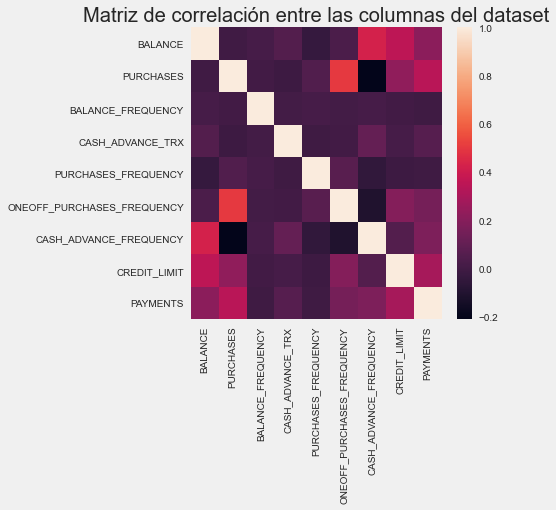

In [277]:
corr = datos.corr()

plt.figure(figsize=(5,5))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('Matriz de correlación entre las columnas del dataset')
plt.show()

Podemos ver que no hay correlaciones ni positivas ni negativas muy fuertes entre los datos. La correlación positiva más alta, de alrededor de 0.6, es entre PURCHASES_FREQUENCY y ONEOFF_PURCHASES_FREQUENCY. Quizá podría pensarse en eliminarse alguna de estas columnas, pero estas son decisiones que deben tomarse más adelante.

##### Variables categóricas:
En caso de datos categóricos según el diccionario conoceremos las categorías, los números de registro por categoría, en especial para las categorías con mayor representación en los datos. En este caso, veremos sólo la distribución de género; pues de acuerdo con el pandas profiling, los datos de los IDs de los consumidores son únicos.

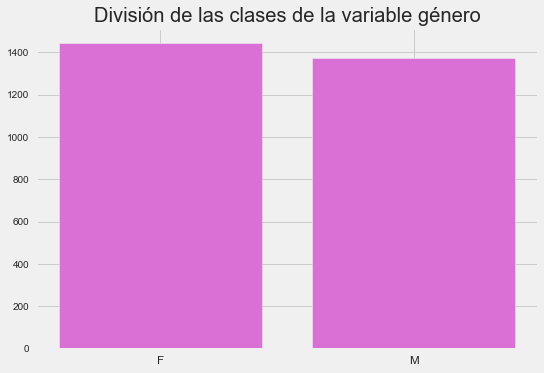

Veamos la cantidad de datos en cada clase: 


,GENDER
F,1443
M,1373


In [278]:
val_counts_gender = datos['GENDER'].value_counts()
plt.bar(range(len(val_counts_gender)), val_counts_gender.values, align='center',color='orchid')
plt.xticks(range(len(val_counts_gender)), val_counts_gender.index.values, size='small')
plt.title('División de las clases de la variable género')
plt.show()
print('Veamos la cantidad de datos en cada clase: ')
datos['GENDER'].value_counts().to_frame()

Podemos ver que hay una cantidad de datos de cada categoría muy parecida; no obstante, teniendo en cuenta la cantidad total de datos del dataset, podemos ver que hay ciertos valores nulos (la totalidad de ambas categorías no suma el total de datos).

**NOTA:** Es importante mencionar que, en el contexto de las tareas por agrupación y dado el enunciado, no es necesario hacer una partición train-test de los datos. 

## 2. Preparación de datos.

Realizaremos el proceso para garantizar la calidad de los datos antes de correr los algoritmos.

### Eliminación de columnas 

La columna CUSTID es la identificacion de la tarjeta de crédito. Como esta columna no representa ningún dato significativo para el proceso de la creación del modelo, procedemos a eliminarla. Esto se debe a que los IDs no son relevantes en la mayoría de trabajos de aprendizaje automático. 

Como se indicó en el perfilamiento de los datos, las columnas OneOffPurchases_frecuency y Gender cuentan con un porcentaje de celdas faltantes significativo: 49.5% y 49.1%, respectivamente. Por esta razón si realizamos imputación de datos para estas columnas, estaríamos sesgando los datos, por lo que también serán eliminadas.

In [279]:
datos.drop(["GENDER", "CUST_ID", "ONEOFF_PURCHASES_FREQUENCY"], axis=1, inplace=True)
print("Número de filas o datos: {}".format(len(datos)))
print("Número de columnas o variables: {}".format(len(datos.columns)))

Número de filas o datos: 5530
Número de columnas o variables: 12


### Manejo de valores atipicos / no válidos
Primero, revisaremos cuales son los datos no válidos que tenemos en los datos, como los que identificamos con ??, ñ? en el perfilamiento.

In [280]:
def get_not_numeric_values(datos):
    # Vemos todos los valores distintos (únicos) que tiene el dataframe.
    valores_distintos = list(datos.apply(pd.value_counts).index)
    valores_no_numericos = []
    # Interamos sobre los valores distintos
    for val in valores_distintos:
        try:
            # Intentamos hacer el cast a float
            numero = float(val)
        except:
            # Si hay datos no numericos, los agregamos a la lista
            valores_no_numericos.append(val)
    return valores_no_numericos

In [281]:
valores_no_numericos=get_not_numeric_values(datos)
print('Los valores no numéricos son:\n {}'.format(', '.join(map(str,valores_no_numericos))))

Los valores no numéricos son:
 0.0?ñ, 0?ñ, 1.721007?ñ, 1090.811625?ñ, 10?ñ, 1117.265123?ñ, 117.258435?ñ, 11?ñ, 120.178123?ñ, 1210.778254?ñ, 1222.355238?ñ, 1227.092304?ñ, 1232.547913?ñ, 1253.401339?ñ, 1254.849545?ñ, 1265.552953?ñ, 127.542299?ñ, 1297.077512?ñ, 1299.253842?ñ, 12?ñ, 130.626533?ñ, 1344.577203?ñ, 135.26688?ñ, 139.382867?ñ, 1414.866215?ñ, 1452.265916?ñ, 1454.215974?ñ, 1460.777849?ñ, 147.347019?ñ, 1480.171443?ñ, 149.110815?ñ, 14?ñ, 1516.892745?ñ, 158.851964?ñ, 15?ñ, 162.269258?ñ, 162.941232?ñ, 163.353616?ñ, 167.584529?ñ, 168.805075?ñ, 1708.514116?ñ, 172.574308?ñ, 175.755159?ñ, 178.143055?ñ, 178.313275?ñ, 17?ñ, 18.904244?ñ, 183.230915?ñ, 184.288462?ñ, 185.805592?ñ, 1863.759832?ñ, 188.591146?ñ, 1983.897997?ñ, 19?ñ, 1?ñ, 200.254118?ñ, 202.991548?ñ, 216.195821?ñ, 21?ñ, 229.289946?ñ, 229.94082?ñ, 22?ñ, 233.788637?ñ, 234.095576?ñ, 237.378894?ñ, 239.606651?ñ, 23?ñ, 247.32444?ñ, 254.022569?ñ, 2555.103715?ñ, 25?ñ, 2625.644609?ñ, 269.655125?ñ, 26?ñ, 2705.839993?ñ, 271.370767?ñ, 273.5254

Podemos ver que la mayoria de estos datos no válidos tienen un número y al final un "?ñ". Asumiremos que esto fue un error de tipeo al momento de ingresar los datos, por lo que eliminaremos el "?ñ" y dejaremos el número. Mas adelante revisaremos si los datos cumplen con los rangos establecidos.
La siguiente funcion nos ayudará a limpiar estos datos:

In [282]:
# Function to clean the names-https://www.geeksforgeeks.org/replace-values-in-pandas-dataframe-using-regex/
def clean_numbers(Column_name):

    if re.search('\?ñ', Column_name): 
        # Extract the position of beginning of pattern
        pos = re.search('\?ñ', Column_name).start()
        # return the cleaned name
        return Column_name[:pos]
  
    else:
        # if clean up needed return the same name
        return Column_name

Aplicamos la funcion anterior en todas las columnas. Como estamos trabajando con expresiones regulares, evitaremos errores, se convierten todos valores a <code>str</code>. Cabe resaltar que mas adelante se realizará la debida transformación a <code>float</code>.

In [283]:
for column in datos.columns:
    # Updated the columns
    datos[column]=datos[column].apply(str)
    datos[column] = datos[column].apply(clean_numbers)

Ahora, rectificaremos que efectivamente los datos que tenian los caracteres "?ñ" fueron corregidos 

In [284]:
valores_no_numericos=get_not_numeric_values(datos)
print('Los valores no numéricos ahora son: {}'.format(valores_no_numericos))

Los valores no numéricos ahora son: ['??']


Vemos ahora que el único valor inconsistente en los datos es: ??. Veamos cuántos de estos valores hay en el dataset:

In [285]:
num_inconsistentes = len(datos[(datos.values == '??').any(axis=1)])
print('El número de filas con datos inconsistentes es: {}'.format(num_inconsistentes))
print ("Esto representa el: {:.2f}% de los datos".format(num_inconsistentes/len(datos)*100))

El número de filas con datos inconsistentes es: 291
Esto representa el: 5.26% de los datos


Para evitar eliminar el 5% de los datos, estos se convertirán en datos <code>np.NaN</code> y serán manejados en más adelante, con los demás datos nulos del dataset.
Para esto, usaremos una funcion que nos convertirá todo lo que no se pueda convertir a <code>float</code> a <code>np.NaN</code>. Es una función parecida a la trabajada anteriormente, por lo que sabemos con seguridad que los unicos datos que evitan que estas columnas se puedan convertir a <code>float</code> son los "??". 

Adicionalmente, esta función ayudará a realizar la conversion de las columnas a <code>float</code>

In [286]:
def convert_to_NaN(x):
    try:
        return float(x)
    except:
        return np.NaN

In [287]:
for column in datos.columns:
    datos[column] = datos[column].apply(convert_to_NaN)

Podemos verificar ahora que no hay datos no numéricos y que todas las columnas han sido transformadas a <code>float64</code>.

In [288]:
valores_no_numericos=get_not_numeric_values(datos)
print('La cantidad de valores no numéricos es: {}'.format(len(valores_no_numericos)))
print(datos.dtypes)

La cantidad de valores no numéricos es: 0
BALANCE                   float64
PURCHASES                 float64
BALANCE_FREQUENCY         float64
CASH_ADVANCE              float64
CASH_ADVANCE_TRX          float64
PURCHASES_FREQUENCY       float64
PURCHASES_TRX             float64
CASH_ADVANCE_FREQUENCY    float64
CREDIT_LIMIT              float64
PAYMENTS                  float64
MINIMUM_PAYMENTS          float64
TENURE                    float64
dtype: object


### Manejo de valores fuera de rango

En el perfilamiento de datos identificamos algunas variables tienen valores fuera de rango según el diccionario por BancAlpes. Sin embargo, revisaremos si hay otras variables que presenten valores fuera de rango; especialmente aquellas que, al salir con inconsistencias, no podíamos realizar un análisis preliminar de coherencia con el rango definido por el negocio.

In [289]:
print ("{:<25} {:<25} {:<20}".format('VARIABLE','MIN','MAX',))
print ("-----------------------------------------------------------------------")
for column in datos.columns:
    print ("{:<25} {:<25} {:<20}".format( column, datos[column].min(),datos[column].max()))

VARIABLE                  MIN                       MAX                 
-----------------------------------------------------------------------
BALANCE                   -4587.892398              7390.19856          
PURCHASES                 0.0                       9661.37             
BALANCE_FREQUENCY         0.0                       1000.0              
CASH_ADVANCE              0.0                       6448.247202         
CASH_ADVANCE_TRX          0.0                       18000.0             
PURCHASES_FREQUENCY       0.0                       1000.0              
PURCHASES_TRX             0.0                       28000.0             
CASH_ADVANCE_FREQUENCY    0.0                       1.5                 
CREDIT_LIMIT              50.0                      12500.0             
PAYMENTS                  0.056466                  9933.62261          
MINIMUM_PAYMENTS          0.019163                  1998.400995         
TENURE                    -12.0                     

Con esta información podemos ver que las variables que tienen datos fuera de rango son:
1. Fuera de límite superior 
    * CASH_ADVANCE:Debe ser [0,5000]. El valor máximo en el dataset es 6448.247202.
    * CASH_ADVANCE_TRX: Debe ser [0,15]: El valor máximo en el dataset es 18000.
    * PURCHASES_FREQUENCY: Debe ser [0,1]: El valor máximo en el dataset es 1000.
    * PURCHASES_TRX: Debe ser [0,30]: El valor máximo en el dataset es 28000.
    * CASH_ADVANCE_FREQUENCY:  Debe ser [0,1]: El valor máximo en el dataset es 1.5.
    * CREDIT_LIMIT:Debe ser [0,10000]: El valor máximo en el dataset es 12500. 
    * MINIMUM_PAYMENTS:Debe ser [0,1200]: El valor máximo en el dataset es 1998.


2. Fuera del límite inferior
    * TENURE:Debe ser [1,12]: Tenemos valores negativos, hasta -12.


3. Fuera de ambos límites
    * BALANCE: Debe ser [0,5000]. De acuerdo con los expertos del negocio, no puede haber balances negativos (foro). Los balances positivos se exceden por menos de 2500.
    



Procederemos a contar cuantos datos fuera de rango hay para cada columna. 

In [290]:
dic_limites={"BALANCE":(0,5000),"BALANCE_FREQUENCY":(0, 1),"CASH_ADVANCE":(0,5000),"CASH_ADVANCE_TRX":(0,15),"PURCHASES_FREQUENCY":(0,1),"PURCHASES_TRX":(0,30),"CASH_ADVANCE_FREQUENCY":(0,1),"CREDIT_LIMIT":(0,10000),"MINIMUM_PAYMENTS":(0,1200),"TENURE":(1,12)}
#El diccionario de parámetro debe ser {"nombreColumna": (valor minimo aceptado, valor máximo aceptado)}
def obtener_numero_outliers (diccionario):
    print ("Datos fuera de rango para:")
    total=0
    for column in dic_limites.keys():
        lim_inf=len(datos[datos[column]<dic_limites[column][0]])
        lim_sup=len(datos[datos[column]>dic_limites[column][1]])
        print ("{:<25} {:<10}".format (column, lim_inf+ lim_sup))
        total+=lim_inf+lim_sup

    print("En total hay {} datos fuera del rango, esto representa el {:.2f}%  en el dataframe".format(total, total/(len(datos))*100))   

In [291]:
obtener_numero_outliers(dic_limites)

Datos fuera de rango para:
BALANCE                   291       
BALANCE_FREQUENCY         160       
CASH_ADVANCE              68        
CASH_ADVANCE_TRX          158       
PURCHASES_FREQUENCY       117       
PURCHASES_TRX             116       
CASH_ADVANCE_FREQUENCY    2         
CREDIT_LIMIT              136       
MINIMUM_PAYMENTS          393       
TENURE                    148       
En total hay 1589 datos fuera del rango, esto representa el 28.73%  en el dataframe


Podemos ver que la cantidad de outliers en el dataset es considerable. Por lo tanto, antes de decidir eliminarlos o imputarlos, es necesario analizar una por una las columnas con outliers.

Veamos las distribuciones de todas las columnas con outliers. Para ello, construimos histogramas con todas las variables relevantes:

In [292]:
def plot_distribuciones(columna, axs, i, j):
    axs[i,j].hist(datos[columna], color='orchid')
    plt.grid(0)
    axs[i, j].set_title(columna)

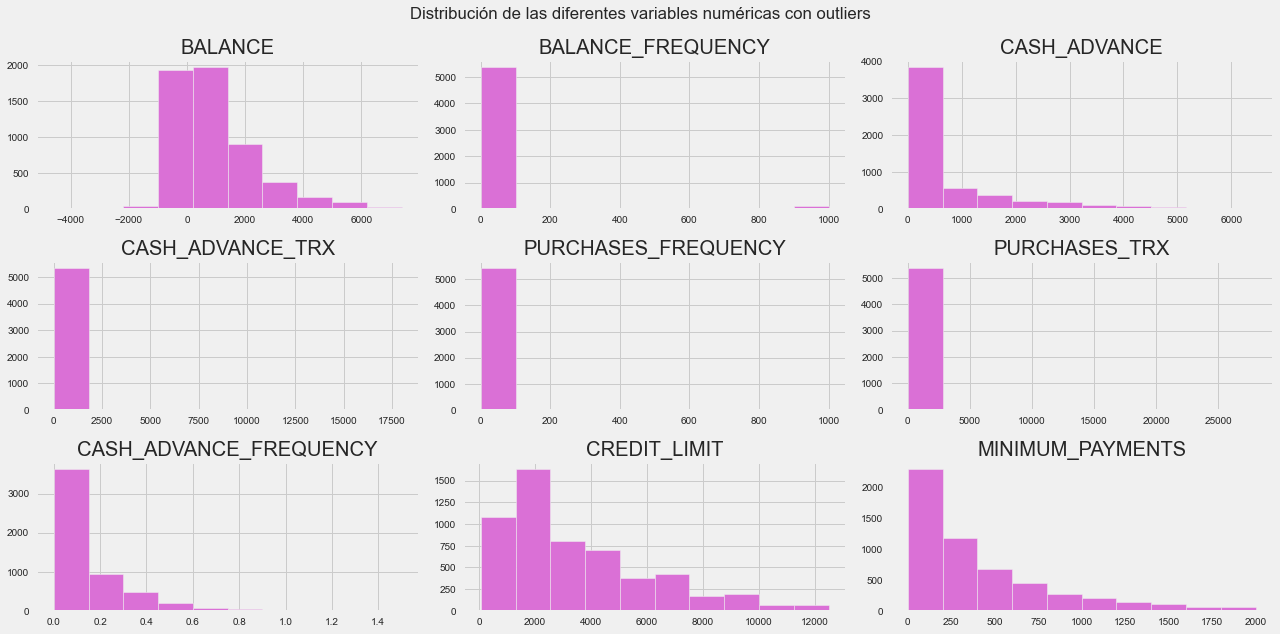

In [293]:
fig, axs = plt.subplots(3,3, figsize=(18,9))
k = 0
for i in range(3):
    for j in range(3):
        plot_distribuciones(list(dic_limites.keys())[k], axs, i, j)
        k += 1
plt.suptitle('Distribución de las diferentes variables numéricas con outliers')
plt.tight_layout()

**BALANCE:** Veamos primero la variable Balance:

In [294]:
print('La cantidad de datos por debajo del límite inferior es: {}'.format(len(datos[datos['BALANCE'] < 0])))
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['BALANCE'] > 5000])))

La cantidad de datos por debajo del límite inferior es: 165
La cantidad de datos por encima del límite superior es: 126


De acuerdo con el negocio y los expertos (foro del curso), los valores negativos son inadmisibles para este contexto. Por lo tanto, deben ser eliminados o imputados, como se hará más adelante. En este caso, como se mencionará más adelante, para variables con casos similares, utilizaremos una imputación con la media.

Para el límite superior, tenemos 126 datos que superan el balance que queda a los usuarios después de hacer sus compras. En lugar de eliminar estos datos, podríamos admitir los valores mayores a 5000 (que, primero, no son muchos y, segundo, superan el monto máximo por muy poco), si asumimos que son errores del conocimiento de datos del negocio.

**CASH_ADVANCE:** Algo similar sucede con esta variable. Veamos cuantos datos fuera del rango superior hay:

In [295]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['CASH_ADVANCE'] > 5000])))

La cantidad de datos por encima del límite superior es: 68


Realmente, el total de datos que se salen del rango es muy bajo y, por tanto, podríamos mantenerlos; suponiendo que es desconocimiento del negocio en este caso. No vemos por qué el usuario no podría más de 5000 en avance por un pago.

**CASH_ADVACE_TRX:** En este caso, el valor máximo del dataset lo tenemos en 18000. Es muy extraño, pues el máximo debería ser 15. Veamos cuántos datos hay mayores a 15, y cuáles son esos datos:

In [296]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['CASH_ADVANCE_TRX'] > 5000])))
datos['CASH_ADVANCE_TRX'][datos['CASH_ADVANCE_TRX'] > 15].value_counts().to_frame()

La cantidad de datos por encima del límite superior es: 11


,CASH_ADVANCE_TRX
16.0,25
17.0,23
19.0,19
1000.0,18
2000.0,14
3000.0,13
18.0,12
20.0,11
5000.0,7
4000.0,5


Podemos ver que, en este caso, hay dos tipos de datos mayores a 15. Aquellos que están entre 16 y 20, y aquellos que están entre 1000 y 18000. Pareciera que estos últimos fueran el resultado de haber multiplicado por 1000 el número de transacciones dadas con CASH_ADVANCE_TRX. Realmente, es difícil que se den 18000 transacciones de este tipo en un banco, y pueden ser errores de digitación en el negocio. 

Podemos acomodar el rango para que el límite superior de la variable sea, ahora, 20 (tiene sentido que algunos usuarios hayan hecho 5 transacciones más con cash in advance, particularmente en escenarios particulares de permisos especiales dados por el negocio). Asimismo, dividiremos entre 1000 todas aquellas transacciones que representan valores entre 1000 y 180000.

In [297]:
datos['CASH_ADVANCE_TRX'].loc[datos['CASH_ADVANCE_TRX'] >= 1000] = datos['CASH_ADVANCE_TRX']/1000

En la anterior línea, dividimos entre 1000 todos los datos con valores mayores o iguales a 1000.

**PURCHASES_FREQUENCY:** Veamos qué sucede con los outliers en este caso:

In [298]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['PURCHASES_FREQUENCY'] > 1])))
datos['PURCHASES_FREQUENCY'][datos['PURCHASES_FREQUENCY'] > 1].value_counts().to_frame()

La cantidad de datos por encima del límite superior es: 117


,PURCHASES_FREQUENCY
1000.000,26
83.333,14
500.000,10
416.667,9
333.333,9
583.333,8
166.667,7
916.667,6
250.000,5
750.000,5


Podemos asumir que en este caso ocurrió algo similar que en la variable anterior. Los valores fuera de rango, parecen multiplicados por 1000. Dividamos, entonces, todos estos valores entre 1000.

In [299]:
datos['PURCHASES_FREQUENCY'].loc[datos['PURCHASES_FREQUENCY'] > 1] = datos['PURCHASES_FREQUENCY']/1000

**PURCHASES_TRX:** Veamos qué sucede con los outliers en este caso:

In [300]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['PURCHASES_TRX'] > 1])))
datos['PURCHASES_TRX'][datos['PURCHASES_TRX'] > 30].value_counts().to_frame()

La cantidad de datos por encima del límite superior es: 3622


,PURCHASES_TRX
7000.0,15
3000.0,13
1000.0,9
8000.0,9
6000.0,8
2000.0,8
12000.0,6
10000.0,5
14000.0,4
15000.0,4


Podemos asumir que en este caso ocurrió algo similar que en la variable anterior. Los valores fuera de rango, parecen multiplicados por 1000. Dividamos, entonces, todos estos valores entre 1000.

In [301]:
datos['PURCHASES_TRX'].loc[datos['PURCHASES_TRX'] > 30] = datos['PURCHASES_TRX']/1000

**CASH_ADVANCE_FREQUENCY:** En este caso, los datos fuera de rango van hasta 1.5, como se vio en etapas previas del entendimiento de los datos. En el histograma, se ve que son pocos los valores que están fuera de rango; y, como en este caso no ocurre lo de la multiplicación por 1000, lo más conveniente es seguir la estrategia de cambiarlos por NaN y después imputar con la media, como se verá más adelante.

**CREDIT_LIMIT:** En este caso, sucede algo similar al límite superior definido para BALANCE. Veamos cuántos datos se salen del rango (i.e. son mayores a 10000):

In [302]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['CREDIT_LIMIT'] > 10000])))

La cantidad de datos por encima del límite superior es: 136


Vemos que son pocos casos e, igual que en casos anteriores, podemos asumir que corresponde a problemas con el límite crediticio que tiene el negocio (quizá los datos están desactualizados). De acuerdo con el histograma, el valor máximo es apenas 12500, no muy distante del 10000 (proporcionalmente). Por lo tanto, podemos simplemente quedarnos con estos datos como están.

**MINIMUM_PAYMENTS:** Veamos qué sucede con los outliers en este caso:

In [303]:
print('La cantidad de datos por encima del límite superior es: {}'.format(len(datos[datos['MINIMUM_PAYMENTS'] > 1200])))

La cantidad de datos por encima del límite superior es: 393


En este caso, considerando el rango dado, el límite superior sí es excedido considerablemente. Con esta variable, podemos saber el mínimo número de pagos que hizo un usuario, y quizá más de 1200 es mucho. En este caso, para no asumir más información sobre el negocio, preferimos eliminarlos e imputarlos posteriormente con la media.

**TENURE:** En este caso, veamos los datos que son menores a 0:

In [304]:
print('La cantidad de datos por debajo del límite inferior es: {}'.format(len(datos[datos['TENURE'] < 0])))
datos['TENURE'][datos['TENURE'] < 0].value_counts().to_frame()

La cantidad de datos por debajo del límite inferior es: 148


,TENURE
-12.0,124
-11.0,8
-10.0,6
-7.0,6
-9.0,2
-8.0,2


Vemos que solamente hay 6 valores, y que todos están en el rango [-7,-12]. Asumimos, entonces, que es un error de tipeo y que, en realidad, todos los valores son positivos. Por ello, usando la función <code>abs()</code>, transformamos a positivo todos los valores negativos de esta columna:

In [305]:
datos['TENURE'] = abs(datos['TENURE'])

----
Con esto, concluimos el análisis de cada columna por separado. Como dijimos previamente, hay algunos datos que, sin lugar a dudas deben ser imputados. Para ello, seguiremos la siguiente estrategia: Para todas las columnas vamos a realizar una imputacion con la media de los datos. Esto debido a que, el porcentaje máximo de celdas a imputar por cada columna sera de de 7.23%, que corresponde al porcentaje de celdas fuera de rango de la columna que más celdas fuera de rango tiene. Para esto, primero debemos volver nulos estos valores. (esta imputación se realizará en la siguiente sección)

In [306]:
def tratar_outliers(x, minimo, maximo):
    if x>=minimo and x<=maximo: 
        return x
    else: 
        return np.NaN

Redefinimos el diccionario con los nuevos valores máximos impuestos y vemos la cantidad de valores fuera de rango con las nuevas consideraciones:

In [307]:
dic_limites={"BALANCE":(0,max(datos["BALANCE"])),"BALANCE_FREQUENCY":(0, 1),"CASH_ADVANCE":(0,max(datos["CASH_ADVANCE"])),"CASH_ADVANCE_TRX":(0,20),"PURCHASES_FREQUENCY":(0,1),"PURCHASES_TRX":(0,30),"CASH_ADVANCE_FREQUENCY":(0,1),"CREDIT_LIMIT":(0,max(datos["CREDIT_LIMIT"])),"MINIMUM_PAYMENTS":(0,1200),"TENURE":(1,12)}
obtener_numero_outliers(dic_limites)

Datos fuera de rango para:
BALANCE                   165       
BALANCE_FREQUENCY         160       
CASH_ADVANCE              0         
CASH_ADVANCE_TRX          0         
PURCHASES_FREQUENCY       0         
PURCHASES_TRX             0         
CASH_ADVANCE_FREQUENCY    2         
CREDIT_LIMIT              0         
MINIMUM_PAYMENTS          393       
TENURE                    0         
En total hay 720 datos fuera del rango, esto representa el 13.02%  en el dataframe


Como era de esperarse, ahora las únicas columnas con outliers son: BALANCE (únicamente con datos negativos), CASH_ADVANCE_FREQUENCY (valores superiores a 1 - ¡son solo dos!) y MINIMUM_PAYMENTS (con valores superiores a 1200). 


A estos valores, aplicamos el tratamiento de los nulos.

In [308]:
for column in dic_limites.keys():
    datos[column] = datos[column].apply( tratar_outliers, args=(dic_limites[column][0], dic_limites[column][1]))

Como era de esperarse, ya no hay outliers en el conjunto de datos:

In [309]:
obtener_numero_outliers(dic_limites)

Datos fuera de rango para:
BALANCE                   0         
BALANCE_FREQUENCY         0         
CASH_ADVANCE              0         
CASH_ADVANCE_TRX          0         
PURCHASES_FREQUENCY       0         
PURCHASES_TRX             0         
CASH_ADVANCE_FREQUENCY    0         
CREDIT_LIMIT              0         
MINIMUM_PAYMENTS          0         
TENURE                    0         
En total hay 0 datos fuera del rango, esto representa el 0.00%  en el dataframe


### Manejo de nulos (celdas vacías)

Revisaremos el numero total de celdas vacías que tenemos

In [310]:
datos_con_null = datos[datos.isna().any(axis=1)]
print('La cantidad de filas con al menos una celda vacía es: ', len(datos_con_null))
print('El porcentaje de filas con celdas vacías es del {:.2f}%'.format((len(datos_con_null)*100)/len(datos)))

La cantidad de filas con al menos una celda vacía es:  1348
El porcentaje de filas con celdas vacías es del 24.38%


Este es un porcentaje considerable de los datos. En realidad, no vale la pena eliminarlos. Por lo tanto, como se dijo antes, seguiremos una estrategia de imputación con la media (al ser variables continuas).

In [311]:
for column in datos.columns:
    datos[column] = datos[column].replace(np.nan, datos[column].mean())

Revisamos que se haya realizado adecuadamente:

In [312]:
datos_con_null = datos[datos.isna().any(axis=1)]
print('La cantidad de filas con al menos una celda vacía es: ', len(datos_con_null))
print('El porcentaje de filas con celdas vacías es del {:.2f}%'.format((len(datos_con_null)*100)/len(datos)))

La cantidad de filas con al menos una celda vacía es:  0
El porcentaje de filas con celdas vacías es del 0.00%


Finalmente, ya con todos los datos tratados, conviene de nuevo realizar un mapa de correlación entre las variables:

In [313]:
corr = datos.corr()
corr

,BALANCE,PURCHASES,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_FREQUENCY,PURCHASES_TRX,CASH_ADVANCE_FREQUENCY,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE
BALANCE,1.000000,-0.008036,0.360356,0.502826,0.425960,-0.208565,-0.113089,0.444207,0.375519,0.223764,0.606602,0.057562
PURCHASES,-0.008036,1.000000,0.106298,-0.156670,-0.178939,0.476312,0.610609,-0.206701,0.229779,0.339212,-0.025184,0.058435
BALANCE_FREQUENCY,0.360356,0.106298,1.000000,0.103014,0.167323,0.185002,0.190262,0.186670,0.043400,0.015781,0.362958,0.078903
CASH_ADVANCE,0.502826,-0.156670,0.103014,1.000000,0.680597,-0.298240,-0.234580,0.648882,0.216414,0.369827,0.340179,-0.099321
CASH_ADVANCE_TRX,0.425960,-0.178939,0.167323,0.680597,1.000000,-0.302048,-0.232614,0.870170,0.068537,0.206692,0.316165,-0.059441
PURCHASES_FREQUENCY,-0.208565,0.476312,0.185002,-0.298240,-0.302048,1.000000,0.833682,-0.343610,0.057688,-0.000889,-0.154588,-0.000206
PURCHASES_TRX,-0.113089,0.610609,0.190262,-0.234580,-0.232614,0.833682,1.000000,-0.273348,0.141918,0.114149,-0.067213,0.114096
CASH_ADVANCE_FREQUENCY,0.444207,-0.206701,0.186670,0.648882,0.870170,-0.343610,-0.273348,1.000000,0.048276,0.176175,0.309288,-0.142891
CREDIT_LIMIT,0.375519,0.229779,0.043400,0.216414,0.068537,0.057688,0.141918,0.048276,1.000000,0.288171,0.124063,0.138775
PAYMENTS,0.223764,0.339212,0.015781,0.369827,0.206692,-0.000889,0.114149,0.176175,0.288171,1.000000,0.183771,0.133590


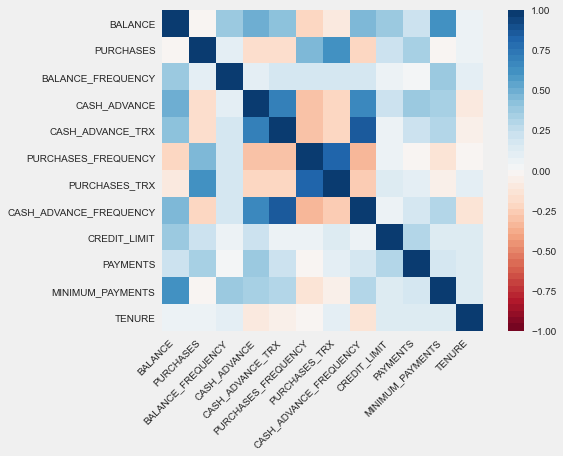

In [314]:
corr = datos.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette("RdBu",50),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



Vemos que después del procesamiento, hay algunas correlaciones que se hacen más evidentes (como, por ejemplo, la de 0.83 entre PURCHASES_FREQUENCY y PURCHASES_TRX, así como la de 0.87 entre CASH_ADVANCE_FREQUENCY y CASH_ADVANCE_TRX. Esto será importante posteriormente en la definición de las columnas que usaremos para los algoritmos.

MINIMUM_PAYMENTS y BALANCE, por ejemplo, también guardan una correlación positiva de 0.6. Esta no es significativamente alta y podría ignorarse, dependiendo del algoritmo.

#### Reescalar datos

In [315]:
trans = MinMaxScaler()
trans.fit(datos)
datos_final= pd.DataFrame(trans.transform(datos),columns= datos.columns)
datos_final

,BALANCE,PURCHASES,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_FREQUENCY,PURCHASES_TRX,CASH_ADVANCE_FREQUENCY,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE
0,0.014606,0.012230,0.875000,0.073325,0.050000,0.125000,0.066667,0.125000,0.196787,0.019401,0.047529,0.333333
1,0.032615,0.000000,1.000000,0.099696,0.050000,0.000000,0.000000,0.083333,0.116466,0.092152,0.162774,1.000000
2,0.121019,0.120480,1.000000,0.000000,0.000000,1.000000,0.400000,0.000000,0.156627,0.091362,0.225544,1.000000
3,0.149481,0.053396,1.000000,0.000000,0.116106,0.833333,0.466667,0.000000,0.212851,0.060570,0.162251,1.000000
4,0.525247,0.001648,1.000000,0.338663,0.450000,0.083333,0.033333,0.333333,0.437751,0.103903,0.942339,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5525,0.088768,0.000000,0.873679,0.228644,0.150000,0.000000,0.000000,0.125000,0.558233,0.091649,0.117582,0.333333
5526,0.002061,0.039746,0.272727,0.000000,0.000000,1.000000,0.400000,0.000000,0.116466,0.057273,0.045402,1.000000
5527,0.138443,0.159183,1.000000,0.038311,0.050000,0.750000,0.833333,0.083333,0.718876,0.107725,0.196206,1.000000
5528,0.129497,0.062600,1.000000,0.139845,0.150000,1.000000,0.400000,0.083333,0.076305,0.081683,0.772460,1.000000


#### Normalizar

In [316]:
"""scaler = Standard()
datos_escalados = scaler.fit_transform(datos)
datos_escalados = normalize(datos_escalados)
datos_final = pd.DataFrame(datos_escalados, columns=datos.columns)"""

'scaler = Standard()\ndatos_escalados = scaler.fit_transform(datos)\ndatos_escalados = normalize(datos_escalados)\ndatos_final = pd.DataFrame(datos_escalados, columns=datos.columns)'

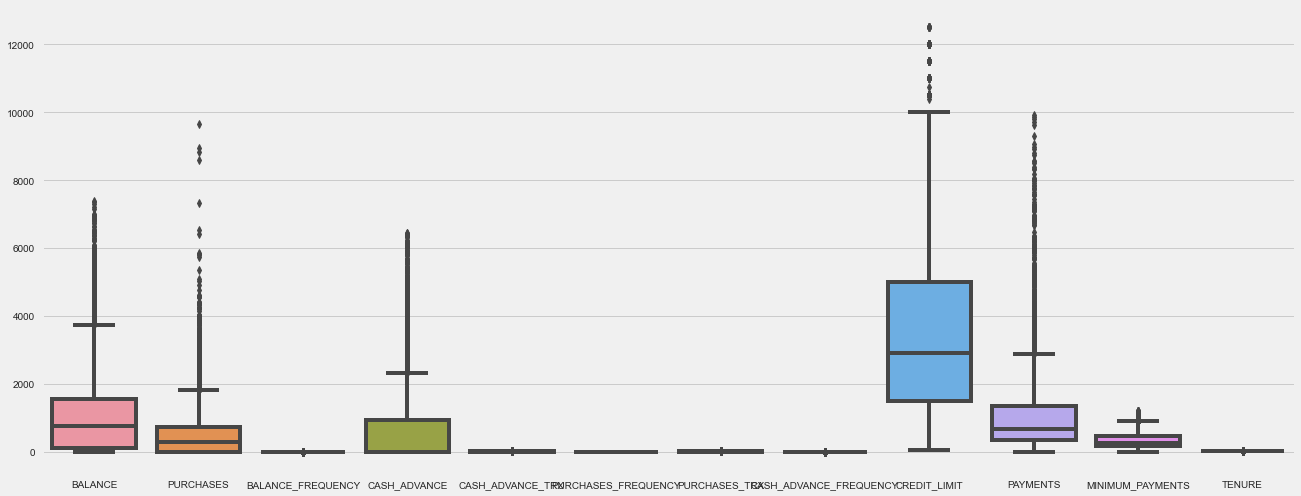

In [317]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=datos, orient="v")

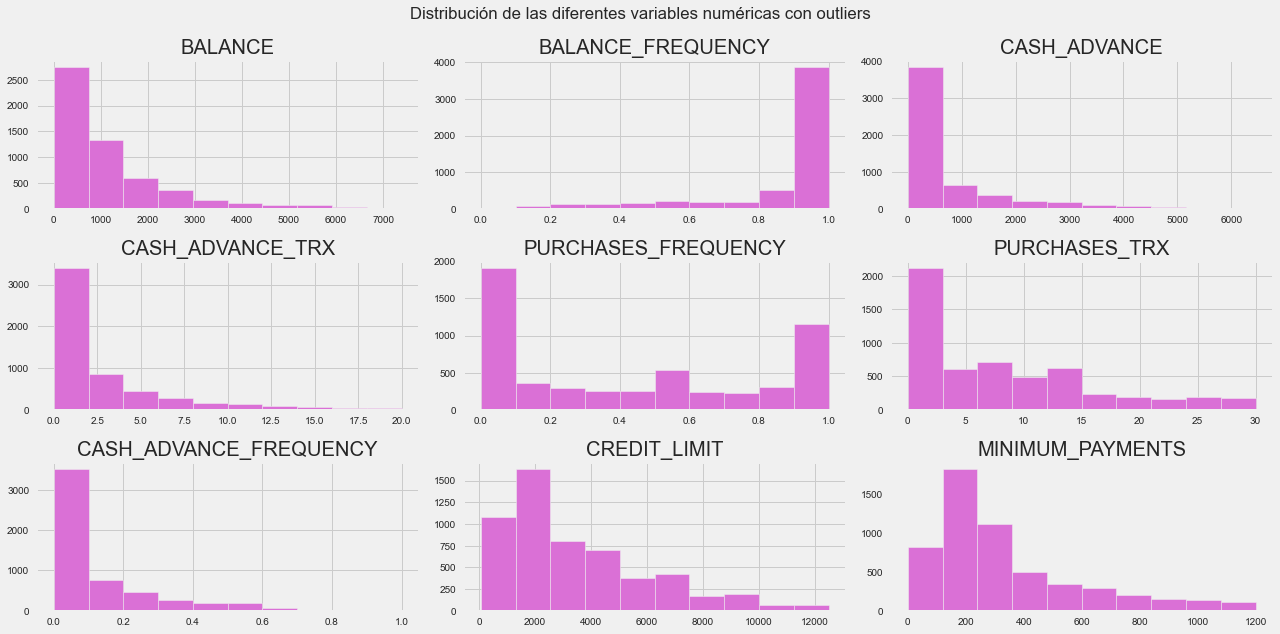

In [318]:
fig, axs = plt.subplots(3,3, figsize=(18,9))
k = 0
for i in range(3):
    for j in range(3):
        plot_distribuciones(list(dic_limites.keys())[k], axs, i, j)
        k += 1
plt.suptitle('Distribución de las diferentes variables numéricas con outliers')
plt.tight_layout()

## 3. Modelamiento - Kmeans
Para este laboratorio, elegimos tres algoritmos de clustering: K-means, hierarchical clustering y el de Álvaro. 

In [319]:
#Creamos una función basada en el concepto de silueta
def plot_silhouette(data, 
                    labels,
                   ylabel = 'Clústeres',
                   xlabel = "Silhouette coefficient",
                   title = 'Silhouette Plot'):
    '''
    Graficar la silueta de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    labels : np.array
        El arreglo con las etiquetas correspondientes
    ylabel  string
        La etiqueta del eje y
    xlabel : string
        La etiqueta del eje x
    title : string
        El titulo de la gráfica        
    '''
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data,
                                        labels,
                                        metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color="red",
                linestyle="--")
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

In [320]:
def plot_distortion(data,
                    k_min=1, 
                    k_max=11,
                    ylabel = 'Distortion',
                    xlabel = 'Number of clusters',
                    title = 'Distortion Plot'):
    '''
    Graficar el codo de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    xlabel : string
        La etiqueta del eje x
    ylabel  string
        La etiqueta del eje y    
    title : string
        El titulo de la gráfica  
    '''
    distortions = []
    for i in range(k_min, k_max):
        km = KMeans(n_clusters=i,
                 init='k-means++',
                 n_init=10,
                 max_iter=300,
                 random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    plt.plot(range(k_min,k_max), distortions, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [321]:
def plot_selectK_silhoute(data,
                    k_min=1, 
                    k_max=11,
                    ylabel = 'Silhouette Coefficient',
                    xlabel = 'Number of clusters',
                    style = 'fivethirtyeight'):
    '''
    Graficar el codo de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    xlabel : string
        La etiqueta del eje x
    ylabel  string
        La etiqueta del eje y    
    title : string
        El titulo de la gráfica  
    '''
    # Crear una lista para almacenar los coeficientes de la silueta para cada valor de k analizado

    silhouette_coefficients = []

    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_coefficients.append(score)
    plt.style.use(style)
    plt.plot(range(k_min, k_max), silhouette_coefficients)
    plt.xticks(range(k_min, k_max))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()    

##### Prueba 1

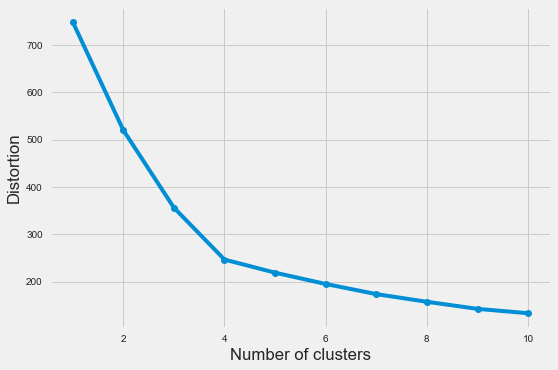

In [322]:
p1= datos_final[['BALANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES', "CREDIT_LIMIT"]]
plot_distortion(p1,1,11)

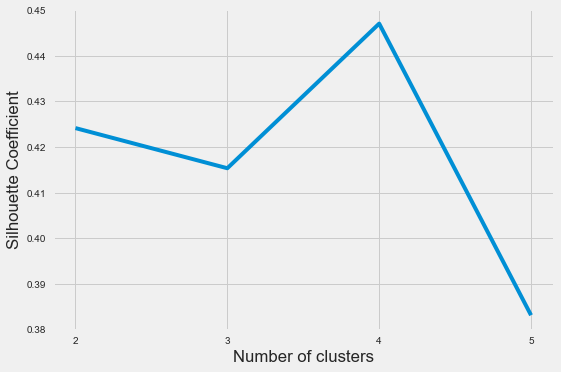

In [323]:
plot_selectK_silhoute(p1, k_min=2, k_max=6)

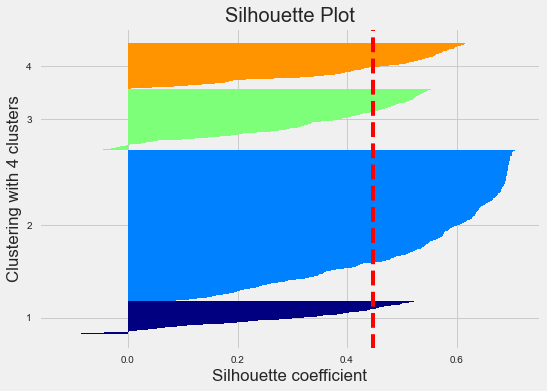

In [324]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(p1)
plot_silhouette(data = p1, 
                labels = km.labels_, 
                ylabel = f'Clustering with {n_clusters} clusters')


#### Prueba 2

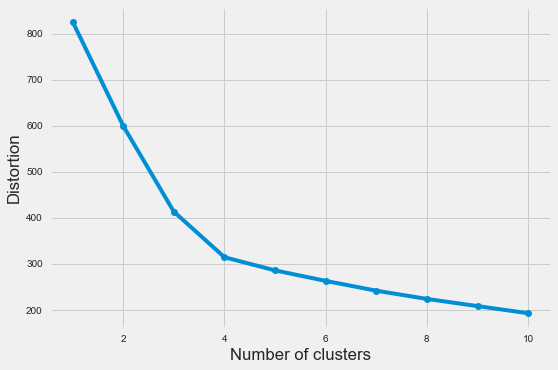

In [325]:
p2= datos_final[[ 'BALANCE_FREQUENCY', 'CASH_ADVANCE', 'PURCHASES', 'CREDIT_LIMIT', 
                 'PAYMENTS']]
plot_distortion(p2,1,11)

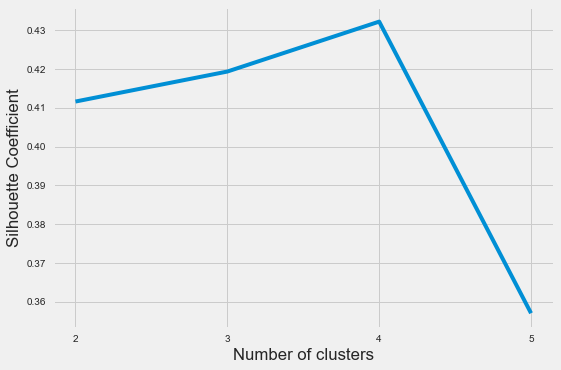

In [326]:
plot_selectK_silhoute(p2, k_min=2, k_max=6)

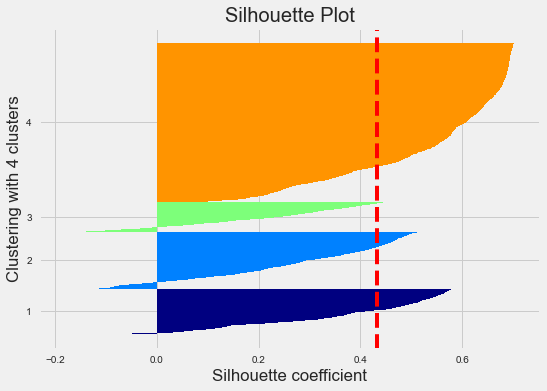

In [327]:
n_clusters =4 
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(p2)
plot_silhouette(data = p2, labels = km.labels_, ylabel = f'Clustering with {n_clusters} clusters')

#### Prueba 3

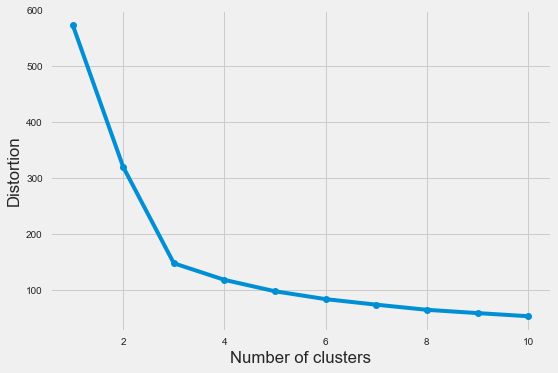

In [328]:
p3=datos_final[['PURCHASES', "CREDIT_LIMIT",  "TENURE"]].copy()
plot_distortion(p3,1,11)


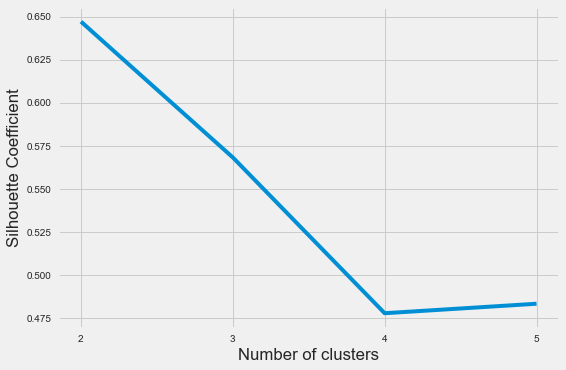

In [329]:
plot_selectK_silhoute(p3, k_min=2, k_max=6)

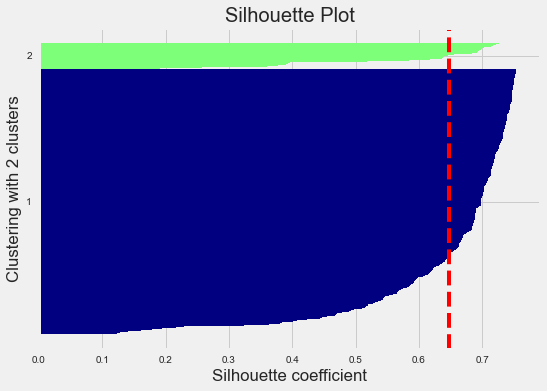

In [330]:
n_clusters = 2
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(p3)
plot_silhouette(data = p3, 
                labels = km.labels_, 
                ylabel = f'Clustering with {n_clusters} clusters')

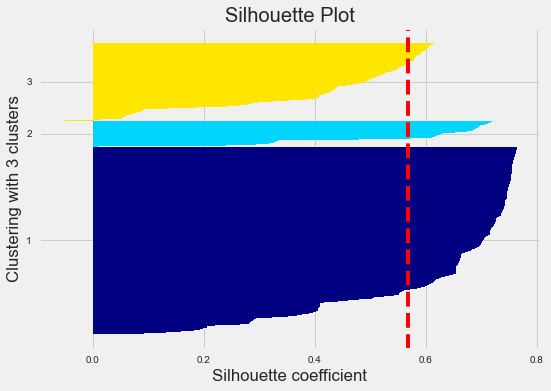

In [331]:
n_clusters = 3
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(p3)
plot_silhouette(data = p3, 
                labels = km.labels_, 
                ylabel = f'Clustering with {n_clusters} clusters')

#### Prueba 4

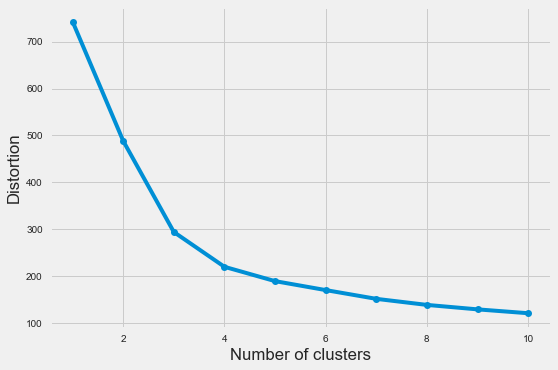

In [332]:
p4=datos_final[["BALANCE", 'PURCHASES', "CREDIT_LIMIT",  "TENURE"]].copy()
plot_distortion(p4,1,11)

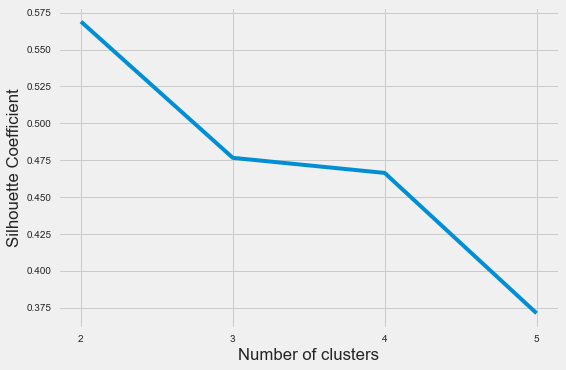

In [333]:
plot_selectK_silhoute(p4, k_min=2, k_max=6)

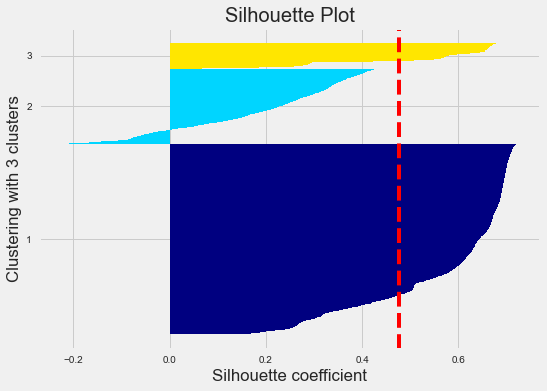

In [334]:
n_clusters = 3
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(p4)
plot_silhouette(data = p4, 
                labels = km.labels_, 
                ylabel = f'Clustering with {n_clusters} clusters')

## Implementacion 

Se escoje la prueba #3 la cual clasifica por 'PURCHASES', "CREDIT_LIMIT",  "TENURE"


In [335]:
n_clusters = 3
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(p3)


KMeans(n_clusters=3, random_state=161)

In [336]:
df_pro1 = pd.DataFrame(km.cluster_centers_, columns = p3.columns)
df_pro1

,PURCHASES,CREDIT_LIMIT,TENURE
0,0.045534,0.174795,0.976275
1,0.042046,0.188796,0.233806
2,0.083357,0.579400,0.979045


In [337]:
df_pro1_t = pd.DataFrame(np.transpose(km.cluster_centers_), columns = range(1, n_clusters +1))
df_pro1_t['column'] = p3.columns
df_pro1_t

,1,2,3,column
0,0.045534,0.042046,0.083357,PURCHASES
1,0.174795,0.188796,0.579400,CREDIT_LIMIT
2,0.976275,0.233806,0.979045,TENURE


<AxesSubplot:xlabel='value', ylabel='column'>

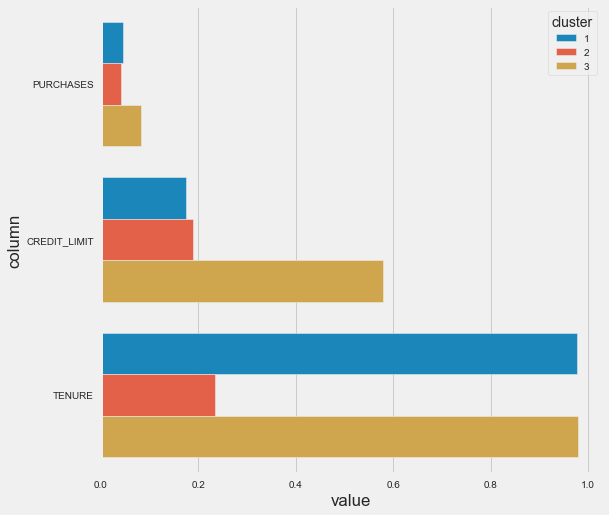

In [338]:
resp = []
for i in range(1, n_clusters +1):
    df1 = df_pro1_t[['column',i]].rename(columns = {i:'value'})
    df1['cluster'] = i
    resp.append(df1)

df_plot = pd.concat(resp, ignore_index = True)


fig = plt.figure(figsize=(8,8))
sns.barplot(data = df_plot, y = 'column', x = 'value', hue = 'cluster', orient = 'h')

In [ ]:
Nota: se seleccionó 3 como cluster y las columnas priobadas en la p3